# Text Mining with sklearn
Using the **20newsgroups** dataset, or a portion thereof.
Following along, with excursions, from http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html. 

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups, fetch_20newsgroups_vectorized
%matplotlib inline


In [13]:
from collections import defaultdict
import re
import sys
from time import time
import numpy as np
from sklearn.feature_extraction import DictVectorizer, FeatureHasher

categories = [
    'alt.atheism',
    'comp.graphics',
    'sci.med',
    'soc.religion.christian',
    'comp.sys.ibm.pc.hardware',
    'misc.forsale',
    'rec.autos',
    'sci.space',
    'talk.religion.misc',
]
# Uncomment the following line to use a larger set (11k+ documents)
#categories = None

categories = categories[:4]

In [14]:
twenty_train = fetch_20newsgroups(subset='train',
                                 categories=categories,
                                 shuffle=True,
                                 random_state=42)
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

So this is already in a **bundle** format where we have keyword access to:
* `data`
* `filenames`
* `target`
* `target_names`

We will use these in training and testing.  First a quick look at the data. Notice that `target` is **integer indices** for the newsgroups.

In [15]:
len(twenty_train.data), len(twenty_train.filenames)

(2257, 2257)

In [16]:
twenty_train.target

array([1, 1, 3, ..., 2, 2, 2])

In [17]:
twenty_train.data[0].split("\n")[:5]

[u'From: sd345@city.ac.uk (Michael Collier)',
 u'Subject: Converting images to HP LaserJet III?',
 u'Nntp-Posting-Host: hampton',
 u'Organization: The City University',
 u'Lines: 14']

## CountVectorizer
First get fast wordcount vectors on the data.
* `c_vec` will be the vector of counts

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer()
X_train_counts = c_vec.fit_transform(twenty_train.data)
X_train_counts.shape

(2257, 35788)

In [101]:
for word in ['the', 'god', 'news', 'algorithm', 'jesus']:
    print('%10s: %d' % (word, c_vec.vocabulary_.get(word)))

       the: 32142
       god: 15521
      news: 22944
 algorithm: 4690
     jesus: 18774


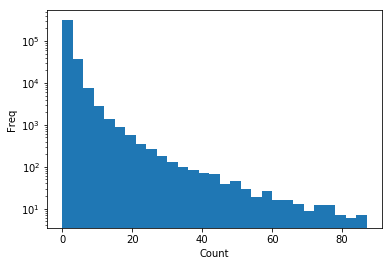

In [124]:
plt.hist(X_train_counts.data,bins=range(0,90,3),log=True)
plt.xlabel('Count')
plt.ylabel('Freq')

## TfidfTransformer
Notice you can use just the _TF_ part, or the full _TFIDF_.  Also note that you can combine `fit` and `transform` into `fit_transform`.

In [51]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_xformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_xformer.transform(X_train_counts)
X_train_tf.shape

(2257, 35788)

In [58]:
sum(X_train_tf.data)

19516.647064279576

In [82]:
tfidf_xformer = TfidfTransformer()
X_train_tfidf = tfidf_xformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2257, 35788)

In [84]:
print(X_train_tf.data[4690], X_train_tf.data[32142])
print(X_train_tfidf.data[4690], X_train_tfidf.data[32142])

0.032241294011 0.0737209780774
0.038305524611 0.0542853706975


In [131]:
[range(5)]

[[0, 1, 2, 3, 4]]

## Classify with MultinomialNB

In [85]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [89]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = c_vec.transform(docs_new)
X_new_tfidf = tfidf_xformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)
for doc, cat in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[cat]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics


## OK, Pipeline it

In [125]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('NB', MultinomialNB())])
text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

And evaluate:

In [126]:
twenty_test = fetch_20newsgroups(subset='test',
                                categories=categories,
                                shuffle=True,
                                random_state=42)
predicted = text_clf.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.83488681757656458

Try an SVM instead -- better for text.

In [127]:
from sklearn.linear_model import SGDClassifier
text_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('svm', SGDClassifier())])
text_svm = text_svm.fit(twenty_train.data, twenty_train.target)

In [128]:
predicted = text_svm.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.92010652463382159

## Better Evaluation

In [129]:
from sklearn import metrics
print(metrics.classification_report(twenty_test.target, 
                                    predicted,
                                    target_names=twenty_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.95      0.83      0.89       319
         comp.graphics       0.90      0.96      0.93       389
               sci.med       0.94      0.91      0.92       396
soc.religion.christian       0.90      0.96      0.93       398

           avg / total       0.92      0.92      0.92      1502



In [130]:
metrics.confusion_matrix(twenty_test.target, predicted)

array([[266,   8,  12,  33],
       [  3, 374,   8,   4],
       [  6,  25, 361,   4],
       [  6,   7,   4, 381]])

OK .. the tutorial continues with GridSearch, some exercises, and a "Where to from here".

## Stemming Etc.

In [20]:
import nltk
lemma = nltk.stem.WordNetLemmatizer()
lemmatize = lemma.lemmatize
lemmatize('news')

'news'

In [22]:
map(lemmatize, ['news','blogs','forums','fora','less'])

['news', u'blog', u'forum', u'forum', u'le']

Which is faster: re.search() or min([...[...] if ...])?

**Answer:** min().  Sidenote: timeit uses 100K loops for re and 1M for min.

In [43]:
import re
s = 'http://www.adsisland.com/?view=selectcity&targetview=post'
%timeit re.search(r'[?&]', s)

100000 loops, best of 3: 2.49 µs per loop


In [44]:
%timeit min([x for x in [s.find('&'), s.find('?')] if x > 0])

The slowest run took 5.12 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.72 µs per loop


In [41]:
%timeit min((x for x in (s.find('&'), s.find('?')) if x > 0))

1000000 loops, best of 3: 1.78 µs per loop


And it seems that shoppping site `net-a-porter.com` detects when we're scraping, and drops us. Alas.  But HG should have that covered.

In [46]:
import requests
requests.get('http://net-a-porter.com', 
             params={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; rv:33.0) Gecko/20100101 Firefox/33.0'},
            timeout=3.05)

ConnectionError: ('Connection aborted.', BadStatusLine("''",))

# Using **thh-classifier**

* Run `__main__.py`
* It sets up an app on port 8889 with a single POST endpoint.
* Append URL to the endpoint and add HTML in the JSON.

Define a function for basic usage.

In [245]:
import json
fc = 'http://localhost:8889/functional-classifier'
def thh_cat(url, html=None):
    if html == None:
        html = requests.get(url).content.decode('utf-8')
    data = json.dumps({'html': html}, ensure_ascii=True)
    r = requests.post('/'.join((fc,url)), data=data)
    return r.json()

Because **facebook** is in `known_sites`, the HTML is irrelevant:

In [246]:
thh_cat('http://www.facebook.com', 'Bad html!')

{u'categories': [u'social']}

**quora.com**:

In [247]:
thh_cat('http://www.quora.com', 'Bad html!')

{u'categories': [u'HTML check failed']}

We can add some fake but legit. HTML. 

In [248]:
html = ['<html><body>',
        '<p>In order to pass <pre>check_input_text()</pre>',
        'the HTML file must have at least 100 characters.',
        '</p></body></html>']
html = '\n'.join(html)

Unsurprisingly, **thh_classifier** doesn't know what to make of that:

In [249]:
thh_cat('http://www.quora.com', html)

{u'categories': [u'UNCERTAIN']}

So let's give it **real HTML**.  

In [250]:
thh_cat('http://reddit.com')  # Defaults to fetching real HTML

{u'categories': [u'UNCERTAIN']}

In [258]:
thh_cat('http://stackoverflow.com')

{u'categories': [u'UNCERTAIN']}

OK, that's weird.  This classifier is _good_ at forums.  But maybe I can't get the HTML from here? No... r.content looks good. Subreddits and posts look like "news":

In [251]:
thh_cat('https://www.reddit.com/r/europe/comments/66h0oa/there_seems_like_to_be_a_pattern/')

{u'categories': [u'news']}

In [252]:
thh_cat('https://www.reddit.com/r/AskReddit/')

{u'categories': [u'news']}

In [253]:
thh_cat('https://www.reddit.com/r/news/')

{u'categories': [u'news']}

In [254]:
thh_cat('https://www.reddit.com/r/funny/')

{u'categories': [u'news']}

In [255]:
thh_cat('https://www.reddit.com/r/gaming/')

{u'categories': [u'news']}

Interesting.

OK, this next one was supposed to be a classifieds site, but the domain is for sale.  So **error** is correct.

In [213]:
thh_cat('http://www.classifieds.ansak.com')

{u'categories': [u'error']}

And it doesn't know Craigslist is classifieds:

In [259]:
thh_cat('https://washingtondc.craigslist.org/nva/')

{u'categories': [u'UNCERTAIN']}